In [7]:
import tensorflow as tf

tf.random.set_seed(1)


In [8]:
#importando os dados
#dados de treinamento não importam, pois o modelo só vai gerar novos dados sintéticos
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test,y_test) = fashion_mnist.load_data()

In [9]:
import numpy as np

#combinando os conjuntos de treino e teste
dataset = np.concatenate([x_train, x_test], axis = 0)
#normalizando as imagens  de 0-155 para 0-1
dataset = np.expand_dims(dataset, -1).astype("float32") / 255

In [10]:
#redimensionando os dados para as o input na CNN
BATCH_SIZE = 64

dataset = np.reshape(dataset, (-1, 28, 28, 1))
#objeto base tensorflow
dataset = tf.data.Dataset.from_tensor_slices(dataset)
#setando o batch size para ler mais de uma imagem por vez
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

In [13]:
#CRIANDO GERADOR

from tensorflow import keras
from tensorflow.keras import layers

#o input do gerador é um vetor de ruído,
# o ruído é um hiper-arâmetro que necessita de ajuste

NOISE_DIM = 150 #valores de ruído

#modelo gerador que utiliza camadas upsampling

generator = keras.models.Sequential([
  keras.layers.InputLayer(input_shape=(NOISE_DIM,)),
  layers.Dense(7*7*256),
  layers.Reshape(target_shape=(7, 7, 256)),
  layers.Conv2DTranspose(256, 3, activation="leaky_relu", strides=2, padding="same"),
  layers.Conv2DTranspose(128, 3, activation="leaky_relu", strides=2, padding="same"),
  layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")
])

generator.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 12544)               │       1,894,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 14, 14, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 28, 28, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,780,417 (10.61 MB)

 Trainable params: 2,780,417 (10.61 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# DISCRIMINADOR

#modelo discriminador com camadas downsampling
discriminator = keras.models.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28, 1)),
  layers.Conv2D(256, 3, activation="relu", strides=2, padding="same"),
  layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),
  layers.Flatten(),
  layers.Dense(64, activation="relu"),
  layers.Dropout(0.2),
  layers.Dense(1, activation="sigmoid")
])

discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 256)         │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │         401,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 699,137 (2.67 MB)

 Trainable params: 699,137 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

**otimizadores, funções de perda e métricas**

In [15]:
#definindo taxas de aprendizado para o geardor e discriminador
optimizerG = keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5)
optimizerD = keras.optimizers.Adam(learning_rate=0.00003, beta_1=0.5)

#classificador binário
lossFn = keras.losses.BinaryCrossentropy(from_logits=True)

#accuracy metric
gAccMetric = tf.keras.metrics.BinaryAccuracy()
dAccMetric = tf.keras.metrics.BinaryAccuracy()

In [16]:
@tf.function
def trainDStep(data):
  batchSize = tf.shape(data)[0]
  #vetor de ruído amostrado de uma distribuição gaussiana para entrada do gerador

  noise = tf.random.normal(shape=(batchSize, NOISE_DIM))

  y_true = tf.concat(
      [
          tf.ones(batchSize, 1),
          tf.zeros(batchSize, 1)
      ],
      axis = 0
  )

  #gravando os gradientes calculados
  with tf.GradientTape() as tape:
    fake = generator(noise)

    x = tf.concat([data, fake], axis = 0)
    y_pred = discriminator(x)

    discriminatorLoss = lossFn(y_true, y_pred)

  #atualizando os pesos
  grads = tape.gradient(discriminatorLoss, discriminator.trainable_weights)
  optimizerD.apply_gradients(zip(grads, discriminator.trainable_weights))

  dAccMetric.update_state(y_true, y_pred)

  #retornando o loss
  return {
      "discriminator_loss": discriminatorLoss,
      "discriminator_accuracy": dAccMetric.result()
  }

In [17]:
#definindo a função de treinamento para o discriminador
@tf.function

def trainGstep(data):
  batchSize = tf.shape(data)[0]
  noise = tf.random.normal(shape=(batchSize, NOISE_DIM))
  y_true = tf.ones(batchSize, 1)

  with tf.GradientTape() as tape:
    y_pred = discriminator(generator(noise))
    generatorLoss = lossFn(y_true, y_pred)

    grads = tape.gradient(generatorLoss, generator.trainable_weights)
    optimizerG.apply_gradients(zip(grads, generator.trainable_weights))

    gAccMetric.update_state(y_true, y_pred)

    return {
      "generator_loss": generatorLoss,
      "generator_accuracy": gAccMetric.result()
   }

In [18]:
#função para visualizar as imagens geradas ao longo do treinamento
from matplotlib import pyplot as plt

def plotImages(model):
  images = model(np.random.normal(size=(81, NOISE_DIM)))

  plt.figure(figsize=(9, 9))

  for i, image in enumerate(images):
    plt.subplot(9, 9, i+1)
    plt.imshow(np.squeeze(image, -1),cmap = "Greys_r")
    plt.axis('off')
  plt.show();

**Treinamento**

In [19]:
for epoch in range(30):

  dLossSum = 0
  gLossSum = 0
  dAccSum = 0
  gAccSum = 0
  cnt = 0
  #percorre o dataset um subconjunto por vez
  for batch in dataset:

    #treinando discriminador
    dLoss = trainDStep(batch)
    dLossSum += dLoss['discriminator_loss']
    dAccSum += dLoss['discriminator_accuracy']

    #treinando gerador
    gLoss = trainGstep(batch)
    gLossSum+= gLoss['generator_loss']
    gAccSum += gLoss['generator_accuracy']

    cnt += 1

  print("E:{},Loss g:{:0.4f}, Loss D :{:0.4f}, Acc G:%{:0.2f}, Acc D: %{:0.2f}".format(
        epoch,
        gLossSum/cnt,
        dLossSum/cnt,
        100 * gAccSum/cnt,
        100* dAccSum/cnt

  ))

  if epoch % 2 == 0:
    plotImages(generator)


Output hidden; open in https://colab.research.google.com to view.

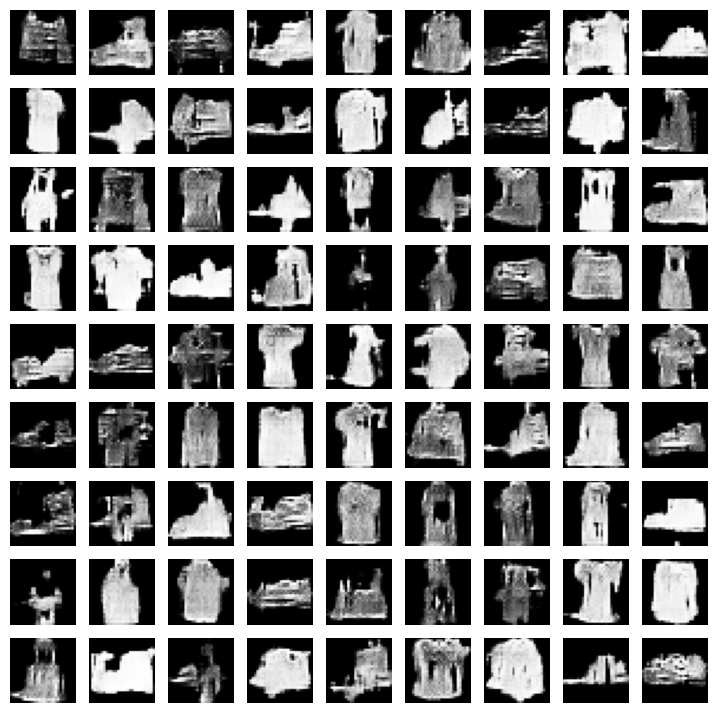

In [24]:
#gerando imagens com o modelo treinado

images = generator(np.random.normal(size=(81, NOISE_DIM)))

from matplotlib import pyplot as plt

plt.figure(figsize=(9,9))

for i, image in enumerate(images):
  plt.subplot(9,9,i+1)
  plt.imshow(np.squeeze(image, -1), cmap="Greys_r")
  plt.axis('off')

plt.show();